В данном задании требуется работать с библиотекой Gym, которую не проходили в рамках этой лекции. На следующем занятии *Политические методы обучения, алгоритм REINFORCE* будет рассматриваться синтаксис этой библиотеки, но вы также можете найти синтаксис в документации и в шаблонных кодах, которые выложили в интернет.

В этом задании требуется реализовать классический алгоритм Q-обучения на среде 'Taxi-v3' - т.е. нельзя использовать нейронные сети, нужно использовать Q-таблицу. В данной среде всего 500 уникальных состояний, так что Q-таблица будет работать лучше и обучаться намного быстрее, чем нейронная сеть. 

Нужную документацию можно найти по следующей ссылке: https://gym.openai.com/envs/Taxi-v3/

Импортируем библиотеку gym.

In [ ]:
!pip install imageio==2.4.1

In [ ]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Sequential, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
import random                              #Импортируем модуль для генерации рандомных чисел
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2064384/45929032 bytes (4.5%)5341184/45929032 bytes (11.6%)8429568/45929032 bytes (18.4%)11730944/45929032 bytes (25.5%)14983168/45929032 bytes (32.6%)18161664/45929032 bytes (39.5%)21209088/45929032 bytes (46.2%)24141824/45929032 bytes (52.6%)26984448/45929032 bytes (58.8%)29876224/45929032 bytes (65.0%)32956416/45929032 bytes (71.8%)35938304/45929032 bytes (78.2%)

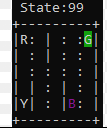

Мы будем взаимодействовать со средой, которая называется `taxi-v3`. Агент управляет такси, которая должна забирать пассажиров и доставлять их в указанные точки. Агент имеет 6 действий (забирать, доставлять, двигаться влево, двигаться вправо, двигаться вверх, двигаться вниз).

За неправильные действия (не взял пассажира, не туда сбросил пассажира, слишком долго вёз пассажира) назначаются отрициательные наргады. За своевременную доставку пассажира в нужное назначение даются положительные награды. По этому, цель алгоритма - обучиться правильно забирать и доставлять пассажиров.

In [ ]:
env = gym.make('Taxi-v3')          #Создаем игровую среду через библиотеку gym
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий

Пример состояния: 486
Пространство действий: Discrete(6)


Далее, нам нужно создать Q-таблицу где будут храниться все значения Q(s, a), а также параметры для обучения алгоритма (эпсилон, минимальный допустимый эпсилон, скорость снижения эпсилон, и гамма).

In [ ]:
max_state_num = env.observation_space.n            #Извлекаем количество уникальных состояний в среде
action_space = env.action_space.n                  #Извлекаем количество уникальных действий в каждом состоянии
Q_table = np.zeros((max_state_num, action_space))  #Создаем Q-таблицу используя количество уникальных состояний и уникальных действий

epsilon = 1                 #Задаем параметр эпсилон
min_epsilon = 0.01          #Задаем минимальное значение эпсилон
epsilon_decay_rate = 5e-5   #Задаем скорость снижения эпсилона
gamma = 0.8                 #Задаем параметр гамму

Создаем функцию для выбора действия по состоянию. С вероятностью эпсилон, эта функция будет возвращать рандомное действие и тем исследовать среду, и с вероятностью 1 - эпсилон она будет брать действие с максимальным Q-значением.

In [ ]:
#Функция для выбора действия - принимает на вход состояние среды
def choose_action(state):
  if random.random() < epsilon:            #С вероятностью эпсилон:
    action = env.action_space.sample()     #Берем рандомное действие (исследуем среду)
  else:                                    #С вероятностью 1 - эпсилон:
    action = np.argmax(Q_table[state, :])  #Берем действие с максимальным Q-значением
  return action                       #Возвращаем действие из функции

Также создадим функции для отображения суммарных наград за все эпизоды в процессе обучения. Эта функция практический не менялась из лекционного ноутбука.

In [ ]:
#Создаем функцию для визуализации результата
def plot_rewards(rewards_list):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (20, 8))

  plt.plot(rewards_list, label = "Награда за эпизод")                          #Устанавливаем большой размер полотна
  plt.plot(moving_average(rewards_list), label = "Скользящее среднее награды") #Отрисовываем скользящие средние награды
  plt.xlabel("Эпизод", fontsize = 16)                                    #Добавляем лейблы осей
  plt.ylabel("Награда", fontsize = 16)
  plt.title("Награды за все эпизоды", fontsize = 24)                     #Добавляем заголовок к графику
  plt.legend()                                                           #Добавляем легенду к графику

  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Создаем цикл обучения, внутри которого агент будет взаимодействовать с средой и обучаться.

Обратите внимания, что в данной реализации алгоритма мы используем дополнительный параметр `learning_rate`, который используется в нейронных сетях но раньше не использовался в классическом алгоритме Q-обучения. Этот параметр можно и не использовать конкретно в этой среде, но во многих других случаях, он делает процесс обучения более стабильным.

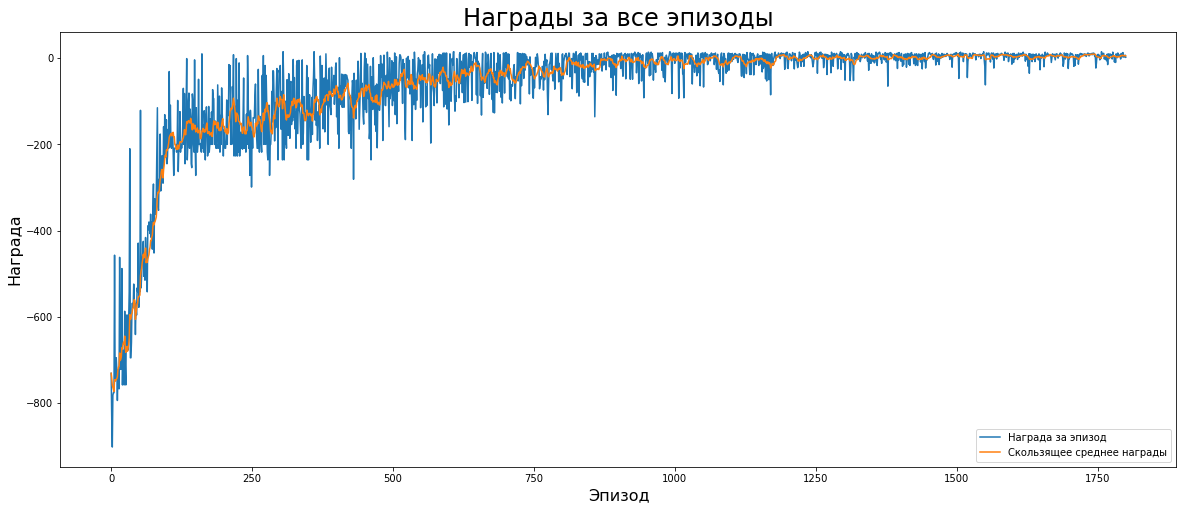

In [ ]:
all_episode_rewards = []  #Создаем список куда будем добавлять сумму наград за весь эпизод

num_episodes = 2000       #Задаем количество эпизодов, по которым будем обучаться
learning_rate = 0.1       #Задаем шаг обучения (это стабилизирует процесс обучения, но в данном случае алгоритм будет обучаться даже если не использовать этот параметр)

for episode_number in range(num_episodes): #В цикле проходим по всем эпизодам
  current_state = env.reset()              #Начинаем новый эпизод, извлекаем текущее состояние
  interval_reward = 0                      #Инициализируем награду за эпизод как 0
  done = False                             #Указываем что эпизод ещё не завершился
  while not done:                          #Пока не дошли до конца эпизода:
    
    action = choose_action(current_state)  #Выбираем действие по текущему состоянию, используя ранее написанную функцию
    
    next_state, reward, done, info = env.step(action) #Подаем действие в среду, получаем следующее состояние, награду, статус завершение эпизода, и прочее

    #Обновляем значение в Q-таблице (критичный момент!!!) - состояние выдается числом, по этмоу мы можем его использовать в качестве индекса.
    Q_table[current_state, action] = (1 - learning_rate) * Q_table[current_state, action] + learning_rate * (reward + gamma * np.max(Q_table[next_state, :]))
    
    interval_reward += reward                                 #Добавляем полученную награду в переменную которая считает сумму наград за эпизод
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)  #Снижаем значение эпсилон
    current_state = next_state                                #Записываем текущее состояние как следующее состояние
  
  all_episode_rewards.append(interval_reward)       #Добавляем сумму наград за эпизод в список
  if episode_number % 200 == 0:                     #Каждые 200 эпизодов:
    plot_rewards(all_episode_rewards)               #Отображаем график с наградами за все эпизоды

Посмотрим, как действует агент после обучения:

In [ ]:
import time                 #Импортируем модуль time (используется для time.sleep чтобы была пауза между кадрами)

current_state = env.reset() #Начинаем новый эпизод, извлекаем текущее состояние
done = False                #Указываем что эпизод ещё не завершился
while not done:             #Пока не дошли до конца эпизода:
  output.clear(wait = True) #Удаляем предидущий вывод ячейки
  env.render()              #Отображаем состояние среды
  action = np.argmax(Q_table[current_state])           #Берём действие с максимальным Q-значением в состоянии (берём действие без эпсилона)
  current_state, reward, done, info = env.step(action) #Извлекаем новое состояние, награду, статус завершения игры, и прочую информацию
  time.sleep(0.5)                                      #Делаем паузу программы на 0.5 секунды чтобы мы могли посмотреть на состояния в виде картинки

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
